# Making Predictions

Interpretability of linear regression models is great as we can derive useful insights by discovering the historical relationship in the data. But, the story does not end here. We can move the ball forward by using estimated model to predict the unknown observations. This is called **prediction**. 

In this checkpoint, we'll cover:

* How to make predictions using estimated linear regression models.

* How to evaluate the prediction performances of regression models.

Throughout the checkpoint, we'll illustrate how to make the predictions by splitting our data into training and test sets. We'll estimate our models using only the traning set. Hence, our models will not see the observations in the test set and the information in the test observations will not be used in the estimation of the models. By doing this, we can read the evaluation results of our models in the test set as if the performance of our models in the unseen real world observations.

## Making predictions using linear regression models

We demonstrate how to make predictions on the medical cost dataset. So, first we need to load it.

In [1]:
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medical_costs'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


In [3]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

insurance_df.region[np.where(np.isin(insurance_df.region, "southwest"))[0]] = 0
insurance_df.region[np.where(np.isin(insurance_df.region, "northwest"))[0]] = 1
insurance_df.region[np.where(np.isin(insurance_df.region, "southeast"))[0]] = 2
insurance_df.region[np.where(np.isin(insurance_df.region, "northeast"))[0]] = 3

In [4]:
# Y is the target variable
Y = insurance_df['charges']

# X is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi']]

Now, we split our data into train and test sets. In doing this, we'll be using scikit-learn's `train_test_split()` method. This method takes the features and the target as well as the test size and random state parameters as inputs. `train_test_split()` method uses `test_size` parameter to decide on how much of the data will be splitted as test. Below, we set this parameter to 0.2 which means we'll use 20% of the data as the test set.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 2140
The number of observations in test set is 536


Now, our features in the training and test sets are assigned to `X_train` and `X_test` respectively. Similarly, the targets are assigned to `y_train` and `y_test`. Next, we use one of our previous models but this time we train it using only the training set:

In [6]:
# We add constant to the model as it's a best practice
# to do so everytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1697.
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        21:04:14   Log-Likelihood:                -21636.
No. Observations:                2140   AIC:                         4.328e+04
Df Residuals:                    2135   BIC:                         4.331e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.161e+04    734.414    -15.804      0.0

It's time to get the predictions! In statsmodels, we make predictions by calling the `predict()` function as the following:

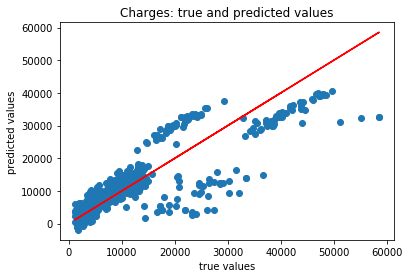

Mean absolute error of the prediction is: 4528.01877221096
Mean squared error of the prediction is: 43385080.46601818
Root mean squared error of the prediction is: 6586.735190215118
Mean absolute percentage error of the prediction is: 43.488284562568985


In [7]:
# We add constant to the model as it's a best practice
# to do so everytime!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



In the graph we see that our model predicts the lower values of the target better than the higher values. Using visualizations help us understand the performance of the models. But, we need to find more accurate ways of assessing our models. Above, we also printed out some metrics to evaluate the performance of the predictions. So, let's discuss what those metrics are.

## Evaluation metrics

When we evaluate the training performance of the linear regression models, we used metrics like R-squared or adjusted R-squared. R-squared measures the ratio of variance in the target variable that is explained by the model. However, when we are making predictions we care more about how close our predictions are to the target rather than the variance in the target variable. So, we usually use other metrics than R-squared to gauge how well our predictions are. Here, we introduce four of the most common ones.

**Mean absolute error (MAE)** is defined by the average of the absolute values of the errors between the true values and the predicted values:

$$ \frac{1}{n} \sum_{i=1}^{n}\lvert y_i-\hat{y}_i\rvert  $$

**Mean squared error (MSE)** is defined by the average of the squared errors between the true values and the predicted values:

$$ \frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2  $$

**Root mean squared error (RMSE)** is defined by the square root of the MSE:

$$ \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2}  $$

**Mean absolute percentage error (MAPE)** is defined by the average of the ratio of the absolute values of the errors to the true values:

$$ \frac{1}{n} \sum_{i=1}^{n}\frac{\lvert y_i-\hat{y}_i\rvert}{y_i}  $$

We can use anyone of the above metrics. But there are some important points to note about them:

* Lower values are desirable for all of the four metrics. The lower the value, the better the performance of the model.

* MAE, MSE and RMSE are in the unit of the target variable but MAPE is unitless. So, MAE, MSE and RMSE are only useful if we compare different models that have the same target variable.

* MSE and RMSE give higher penalty for the large errors than the MAE and MAPE. So, MSE and RMSE are more useful if very high values of the errors are very undesirable.

* For target values very near to zero, MAPE may give problematic picture of the performance as the ratio may go to very high values and this may distort the average. It can also give division by zero errors if some values of the target are zero!


## Improving on the previous model

To compare with the model above, let's use another model where the interaction of bmi and is_smoker is included.

In [8]:
# Y is the target variable
Y = insurance_df['charges']

# This is the interaction between bmi and smoking
insurance_df["bmi_is_smoker"] = insurance_df.bmi * insurance_df.is_smoker

# X is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi', "bmi_is_smoker"]]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 2140
The number of observations in test set is 536


In [10]:
# We add constant to the model as it's a best practice
# to do so everytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     2382.
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        21:04:27   Log-Likelihood:                -21150.
No. Observations:                2140   AIC:                         4.231e+04
Df Residuals:                    2134   BIC:                         4.235e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1951.7418    646.968     -3.017

This second model's R-squared is 0.832 and higher than the previous model where the R-squared is 0.745. This means that the second model's goodness of fit is higher than the previous one. Now, let's make predictions using this model:

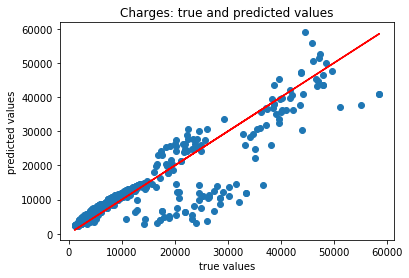

Mean absolute error of the prediction is: 3189.3566717958156
Mean squared error of the prediction is: 29787156.68225798
Root mean squared error of the prediction is: 5457.761141920557
Mean absolute percentage error of the prediction is: 29.60327141228215


In [11]:
# We add constant to the model as it's a best practice
# to do so everytime!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The test set performance of the second model is better than the previous one with respect to all of the four metrics we use! Compared to the previous model, this second model seems to predict high values of the target better. It also seems that the second model predicts the lower values better because the points are more tightly clustered around the red line.

# Assignment

Using the house prices model:

* Split your data into train and test sets.
* Estimate your model in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of prediction performance by adding or removing some variables.